In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import os

In [3]:
ds,s,e = getds('../Output/EB/grid_11_08_set14_run3_0.nc')
ds

<xarray.Dataset>
Dimensions:         (time: 2977, layer: 50)
Coordinates:
  * time            (time) datetime64[ns] 2024-04-18 ... 2024-08-20
  * layer           (layer) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
Data variables: (12/15)
    melt            (time) float64 ...
    refreeze        (time) float64 ...
    runoff          (time) float64 ...
    accum           (time) float64 ...
    snowdepth       (time) float64 ...
    cumrefreeze     (time) float64 ...
    ...              ...
    layerwater      (time, layer) float64 ...
    layerheight     (time, layer) float64 ...
    layerBC         (time, layer) float64 ...
    layerdust       (time, layer) float64 ...
    layergrainsize  (time, layer) float64 ...
    layerrefreeze   (time, layer) float64 ...
Attributes:
    k_snow:          VanDusen
    kw:              4
    threshold_low:   0
    threshold_high:  2
    c5:              0.04
    kp:              2.5
    site:            AB

Site B internal acc: 0.00004 m w.e.
Site B internal acc: 0.00004 m w.e.
Site D internal acc: 0.05800 m w.e.
Site D internal acc: 0.05800 m w.e.
Site T internal acc: 0.07635 m w.e.
Site T internal acc: 0.07635 m w.e.


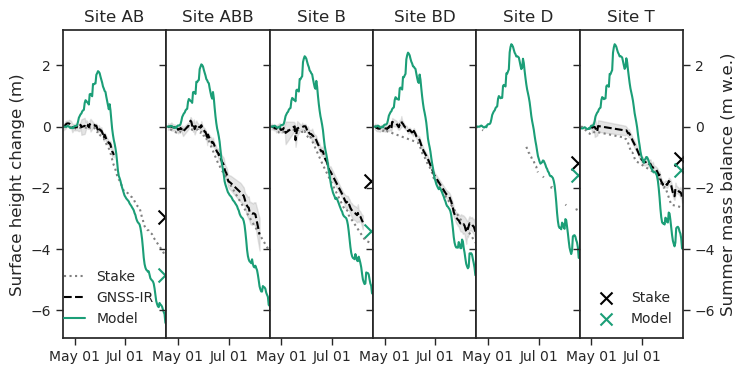

In [5]:
dsdict = {}
id = 0
fig,axes = plt.subplots(1,6,figsize=(8,4),sharey=True,sharex=True,gridspec_kw={'wspace':0})
for i,site in enumerate(['AB','ABB','B','BD','D','T']):
    ds,startdate,enddate = getds(f'../Output/EB/Gulkana_11_08_2024{site}_{id}.nc')
    if site == 'B':
        bds = ds.copy(deep=True)
    dsdict[site] = ds
    axes[i],error = cumulative_mass_balance(site,ds,plot_ax=axes[i])
    axes[i].set_title(f'Site {site}',fontsize=12)
    axes[i].set_ylabel('')
    # direction = '' if error < 0 else '+'
    # text = f'{direction}{error:.3f} m'
    # axes[i].text(enddate-pd.Timedelta(days=80),0.9,text,fontsize=10)
    axes[i].get_legend().remove()
    axes[i].set_xlim(startdate,enddate)
    axes[i].set_xticks(pd.date_range(startdate,enddate,freq='2MS'))
    axes[i].tick_params(labelsize=10)
    if site not in ['ABB','BD']:
        mbmod,mbmeas = cumulative_mass_balance(site,ds,out_mbs=True)
        axes[i].scatter(enddate-pd.Timedelta(days=2),mbmeas,color='black',marker='x',s=100)
        axes[i].scatter(enddate-pd.Timedelta(days=2),mbmod,color=plt.cm.Dark2(0),marker='x',s=100)
axes[-1].set_ylabel('Summer mass balance (m w.e.)',fontsize=12)
axes[-1].yaxis.set_label_position('right')
axes[-1].yaxis.set_ticks_position('both')
axes[-1].tick_params(labelright=True)
axes[0].set_ylabel('Surface height change (m)',fontsize=12)
mod = axes[-1].scatter(np.nan,np.nan,color=plt.cm.Dark2(0),marker='x',s=75)
meas = axes[-1].scatter(np.nan,np.nan,color='black',marker='x',s=75)
axes[-1].legend([meas,mod],['Stake','Model'],facecolor='white',fontsize=10)
axes[0].legend(facecolor='white',fontsize=10,handlelength=1.5)
# plt.savefig(f'/home/claire/research/Output/EB/gulkana_dh_11_04.png',dpi=180,bbox_inches='tight')
plt.show()

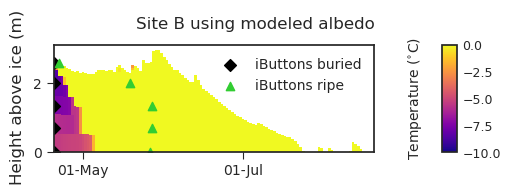

In [ ]:
ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
dsdict['B'] = xr.open_dataset(f'../Output/EB/Gulkana_11_07_2024B_9.nc')
for site in ['B']:
    ripe_dates = {}
    # ksnow = ds.attrs['k_snow']
    if site =='D':
        fig,ax = visualize_layers(dsdict[site],pd.date_range('2024-04-20','2024-08-20'),['layertemp'],ylim=10)
    else:
        fig,ax = visualize_layers(dsdict[site],pd.date_range('2024-04-20','2024-08-20'),['layertemp'])
    
    # Scatter initial heights of iButtons
    depths = np.array([f for f in ripe_dict[site]])
    heights = depths[-1] - depths
    start = np.array([pd.to_datetime('2024-04-20') for _ in range(len(heights))])
    if site == 'D':
        heights += 1200
    ax.scatter(start,heights/100,color='black',marker='D',label='iButtons buried')
    
    # Scatter ripened dates for each sensor
    for depth in ripe_dict[site]:
        if site != 'B':
            height = 150 - depth
        else:
            height = 270 - depth
        if site == 'D':
            height += 1200
        ax.scatter(ripe_dict[site][depth],height/100,marker='^',color='limegreen')
    ax.scatter(np.nan,np.nan,marker='^',color='limegreen',label='iButtons ripe')
    ax.legend()
    ax.grid(False)
    fig.suptitle(f'Site {site} using modeled albedo')
    # plt.show()
    plt.savefig('../Output/EB/snow_ripe_modeleda.png',dpi=180,bbox_inches='tight')

In [27]:
site_profiles = {'A':[],'B':[],'D':[]}
for site in site_profiles:
    fp = '../MB_data/Point/gulkana/pitcore/'
    files = os.listdir(fp)
    profiles = {'sbd':{},'density':{}}
    for f in files:
        s = f.split('_')[-1].split('.')[0]
        if s == site and 'Pit' in f:
            if '_04' in f or '.04' in f:
                year = f[8:12]
                if year[-1] == '.':
                    year = f[7:11]
                year = int(year)
                df = pd.read_csv(fp + f)
                if len(df['sample_bottom_depth']) > 2:
                    profiles['sbd'][year] = df['sample_bottom_depth'].to_numpy() /100
                    density = df['sample_weight'] / df['volume'] * 1000
                    profiles['density'][year] = density.to_numpy()
    site_profiles[site] = profiles

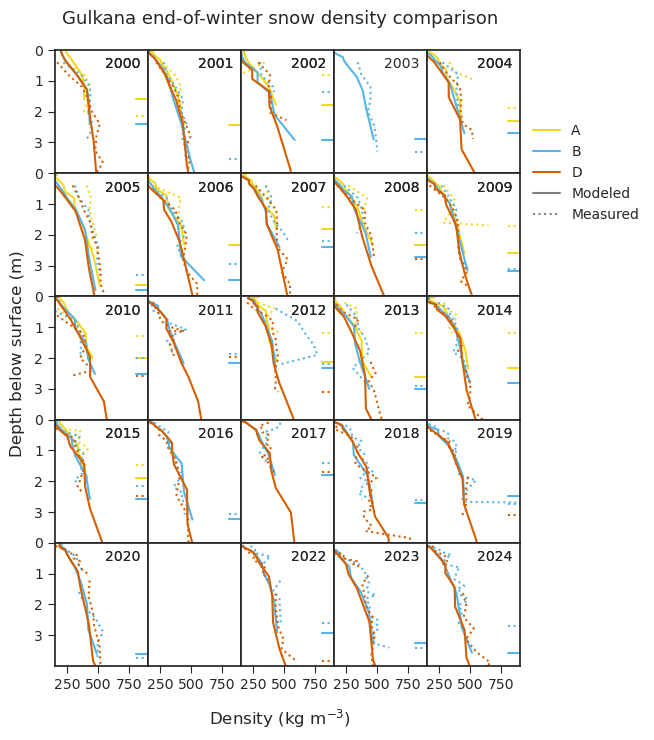

In [31]:
years = np.arange(2000,2025)
fig,axes = plt.subplots(5,5,figsize=(6,8),sharex=True,sharey=True,gridspec_kw={'hspace':0,'wspace':0})
axes = axes.flatten()
norm = mpl.colors.Normalize(vmin=0,vmax=4)
# cmap = mpl.colormaps.get_cmap('viridis')
colors = ['#F4D81C','#56B4E9','#D55E00']
for ss,site in enumerate(site_profiles):
    # color = cmap(norm(ss))
    color = colors[ss]
    ds,s,e =  getds(f'../Output/EB/11_04/Gulkana_2024_11_04_long{site}_2.nc')
    # ds = dsdict[site]['0-2']['0.018']['3']
    profiles = site_profiles[site]
    for y,year in enumerate(years):
        ax = axes[y]
        if year in profiles['sbd']:
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-04-20'))
            lheight = dsyear.layerheight.values
            ldepth = np.array([np.sum(lheight[:i+1])-(lheight[i]/2) for i in range(len(lheight))])
            ldensity = dsyear['layerdensity'].values
            interp_density = np.interp(profiles['sbd'][year],ldepth,ldensity)
            diff = profiles['density'][year] - interp_density
            # ax.plot(diff,profiles['sbd'][year],color=cmap(norm(ss)))
            ax.set_title('')
            ax.text(550,0.6,str(year),fontsize=10)
            snow_idx = np.where(ldensity < 750)[0]

            # plot_meas_density = np.append(profiles['density'][year],900)
            # plot_meas_depth = np.append(profiles['sbd'][year],profiles['sbd'][year][-1])
            # plot_model_density = np.append(ldensity[snow_idx],900)
            # plot_model_depth = np.append(ldepth[snow_idx],ldepth[snow_idx[-1]])
            plot_meas_density = profiles['density'][year]
            plot_meas_depth = profiles['sbd'][year]
            plot_model_density = ldensity[snow_idx]
            plot_model_depth = ldepth[snow_idx]

            ax.plot(plot_model_density,plot_model_depth,color=color)
            ax.plot(plot_meas_density,plot_meas_depth,color=color,linestyle=':')
            snowdepth_mod = ldepth[snow_idx[-1]]
            snowdepth_pit = profiles['sbd'][year][-1]
            ax.plot([800,900],[snowdepth_mod,snowdepth_mod],color=color)
            ax.plot([800,900],[snowdepth_pit,snowdepth_pit],color=color,linestyle=':')
    axes[4].plot(np.nan,np.nan,label=site,color=color)
axes[4].plot(np.nan,np.nan,label='Modeled',color='grey')
axes[4].plot(np.nan,np.nan,label='Measured',linestyle=':',color='grey')
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(4,0)
    ax.set_yticks([0,1,2,3])
    ax.tick_params(length=5,labelsize=10)
    # ax.set_xlim(-350,350)
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    ax.set_xlim(150,900)
    ax.set_xticks([250,500,750])
    ax.axvline(0,linewidth=0.5,color='black')
fig.supxlabel('Density (kg m$^{-3}$)',fontsize=12,y=0.03)
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
# axes[0].legend(bbox_to_anchor=(5.6,0.65))
axes[4].legend(bbox_to_anchor=(1,0.5))
fig.suptitle(f'Gulkana end-of-winter snow density comparison',fontsize=13,y=0.93)
# plt.show()
plt.savefig(f'../Output/EB/gulkana_pits_modeled.png',dpi=220,bbox_inches='tight')

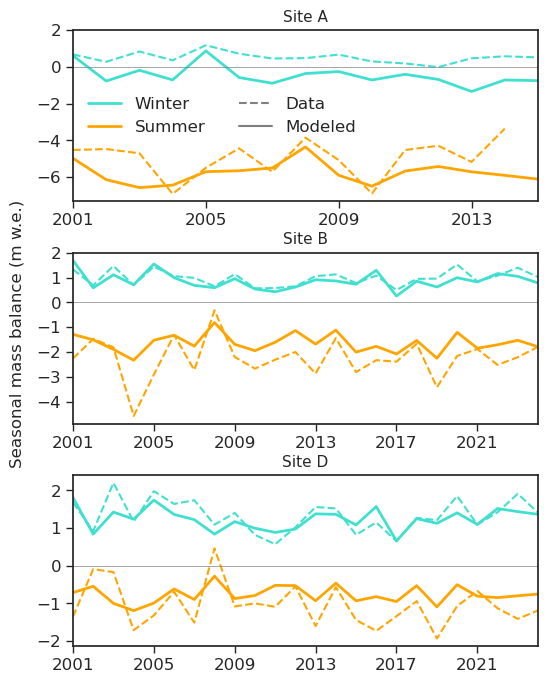

In [12]:
fig, axes = plt.subplots(3,figsize=(6,8),gridspec_kw={'hspace':0.3})
for ss,site in enumerate(['A','B','D']):
    try:
        ads,s,e = getds(f'../Output/EB/11_04/Gulkana_2024_11_04_long{site}_2.nc')
    except:
        # ads,s,e = getds(f'../Output/EB/11_04/Gulkana_2024_11_04_long{site}_1.nc')
        continue
        # ads
    axes[ss] = seasonal_mass_balance(site,ads,plot=True,plot_ax=axes[ss])
    axes[ss].set_ylabel('')
    axes[ss].set_title(f'Site {site}',fontsize=11)
    if ss != 0:
        axes[ss].get_legend().remove()
    else:
        axes[ss].set_yticks([-6,-4,-2,0,2])
    # fig,ax = visualize_layers(ads,pd.date_range(s,s+pd.Timedelta(days=365)),['layerdensity'])
fig.supylabel('Seasonal mass balance (m w.e.)',fontsize=12)
# plt.show()
plt.savefig('../Output/EB/longrun_11_04.png',dpi=180,bbox_inches='tight')
    # assert 1==0

Compare albedo

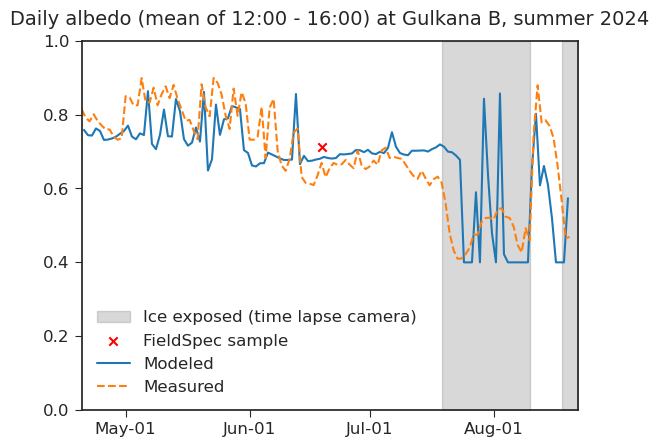

In [67]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/CLAWS_2024_allvars.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
daily_albedo = []
dates = pd.date_range('2024-04-20','2024-08-22',freq='d')
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots()
ax.fill_betweenx(y,[pd.to_datetime('2024-07-19')],[pd.to_datetime('2024-08-10')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='red',label='FieldSpec sample')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(labelsize=12)
ax.set_xticks(pd.date_range(dates[0],dates[-1],freq='MS'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.set_title('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=14,y=1.02)
plt.tick_params(size=5)
dsp = bds.sel(time=pd.date_range('2024-04-20 14:00','2024-08-19 14:00'))
ax.plot(dsp.time,dsp['albedo'],label='Modeled')
ax.plot(dates,daily_albedo,label='Measured',linestyle='--')
ax.legend(fontsize=12)
plt.show()
# plt.savefig('/home/claire/research/Output/EB/albedo_modeled_11_05.png',dpi=150,bbox_inches='tight')


Site B internal acc: 0.00027 m w.e.


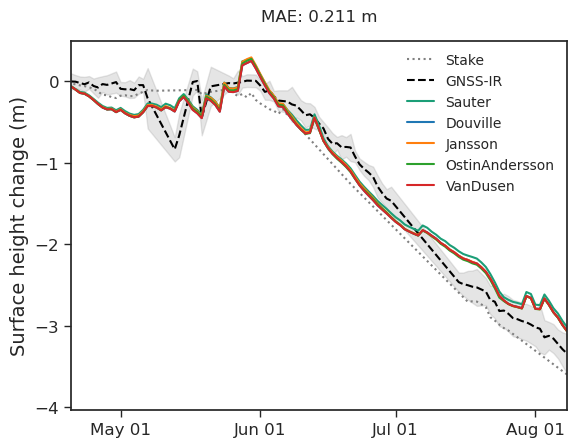

In [38]:
site = 'B'
fig,ax = plt.subplots()
for i in range(5):
    ds,s,e = getds(f'../Output/EB/gridsearch_11_06_B_set{i}_run0_3.nc')
    ksnow = ds.attrs['k_snow']
    if i == 0:
        ax,_ = cumulative_mass_balance(site,ds,plot=True,plot_ax=ax,label='Sauter')
    else:
        ds.dh.values = ds.dh.cumsum().values - ds.dh.isel(time=0).values
        dh = ds.sel(time=pd.date_range('2024-04-20','2024-08-20')).dh
        ax.plot(dh.time,dh.values,label=ksnow)
    ax.legend()

ACTUAL CALIBRATION

In [38]:
# dsdict = {'A':{},'B':{},'D':{}}
dsdict = {'AB':{},'ABB':{},'B':{},'BD':{},'D':{},'T':{}}

# params = {'T_threshold':[[0,1],[0,2],[1.2,3.2]],
#           'Boone_c5':[0.018,0.05],
#           'kp':[1,3]}
params = {'kw':[1,2,2.5,3,4],
          'Boone_c5':[0.018,0.025,0.032,0.04],
          'kp':[2,2.5,3,3.5,4]}
for key in params:
    for v,value in enumerate(params[key]):
        params[key][v] = str(value)
# params = {'kw':[2,2.5,3],
#           'Boone_c5':[0.018,0.025,0.032],
#           'kp':[2,2.5,3]}
for site in dsdict:
    for kw in params['kw']:
        # threshold = str(threshold[0])+'-'+str(threshold[1])
        dsdict[site][kw] = {}
        for c5 in params['Boone_c5']:
            dsdict[site][kw][c5] = {}
            for kp in params['kp']:
                dsdict[site][kw][c5][kp] = {}

In [40]:
# PARSE RUNS
date = '11_08'
path_out = f'/home/claire/research/Output/EB/'
# fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'

for i in range(103):
    for j in range(4):
        # fn = f'{date}_0/grid_{date}_set{i}_run{j}_0.nc'
        # try:
        #     ds,startdate,enddate = getds(path_out+fn)
        #     kp = ds.attrs['kp']
        #     c5 = ds.attrs['c5']
        #     # threshold = ds.attrs['threshold_low']+'-'+ds.attrs['threshold_high']
        #     kw = ds.attrs['kw']
        #     site = ds.attrs['site']
        #     winter,summer = seasonal_mass_balance(site,ds,method='RMSE')
        #     if kp in params['kp'] and kw in params['kw'] and c5 in params['Boone_c5']:
        #         dsdict[site][kw][c5][kp]['dslong'] = ds
        #         dsdict[site][kw][c5][kp]['winter'] = winter
        #         dsdict[site][kw][c5][kp]['summer'] = summer
        # except FileNotFoundError:
        try:
            fn = f'{date}_0/grid_{date}_set{i}_run{j}_0.nc'
            ds,startdate,enddate = getds(path_out+fn)
            kp = ds.attrs['kp']
            c5 = ds.attrs['c5']
            kw = ds.attrs['kw']
            site = ds.attrs['site']
            rmse = cumulative_mass_balance(site,ds,method='RMSE')
            if kp in params['kp'] and kw in params['kw'] and c5 in params['Boone_c5']:
                dsdict[site][kw][c5][kp]['ds2024'] = ds
                dsdict[site][kw][c5][kp]['2024'] = rmse
        except FileNotFoundError:
            continue
        # except KeyError:
        #     print(kp,c5,kw,site,fn)
    # if i % 5 == 0:
    #     print(ds.attrs[param])
    # outdict[site].append(np.mean([winter,summer]))
    # print(ds.attrs['k_snow'],winter,summer,np.mean([winter,summer]))
# best = {}
# for site in sites:
#     best[site] = dsdict[site][np.argmin(outdict[site])]
#     print(site,np.argmin(outdict[site]))
    # simple_plot(ds,['2004-04-20','2004-10-20'],[['albedo']],res='d')

In [27]:
cumulative_mass_balance(site,ds,method='RMSE')

0.2994158364945321

In [295]:
for i in range(81):
    j = 0
    fn = f'{date}_1/grid_{date}_set{i}_run{j}_0.nc'
    ds,startdate,enddate = getds(path_out+fn)
    kp = ds.attrs['kp']
    c5 = ds.attrs['c5']
    # threshold = ds.attrs['threshold_low']+'-'+ds.attrs['threshold_high']
    kw = ds.attrs['kw']
    site = ds.attrs['site']
    winter,summer = seasonal_mass_balance(site,ds)
    dsdict[site][kw][c5][kp]['dslong'] = ds
    dsdict[site][kw][c5][kp]['winter'] = winter
    dsdict[site][kw][c5][kp]['summer'] = summer
    # print(winter,site,kw,c5,kp, dsdict[site][kw][c5][kp]['winter'])

In [41]:
# See what's missing
missing_count = 0
for site in dsdict:
    for kw in params['kw']:
        # threshold = str(threshold[0])+'-'+str(threshold[1])
        for c5 in params['Boone_c5']:
            for kp in params['kp']:
                try:
                    f = dsdict[site][str(kw)][str(c5)][str(kp)]['2024']
                except:
                    print('Missing',site,str(kw),str(c5),str(kp))
                    missing_count += 1
print(missing_count)

Missing AB 1 0.018 2.5
Missing AB 1 0.018 4
Missing AB 1 0.025 2.5
Missing AB 1 0.025 4
Missing AB 1 0.032 3
Missing AB 1 0.04 3
Missing AB 2 0.018 3
Missing AB 2 0.025 3
Missing AB 2 0.032 2
Missing AB 2 0.032 3.5
Missing AB 2 0.04 2
Missing AB 2 0.04 3.5
Missing AB 2.5 0.018 2
Missing AB 2.5 0.018 3.5
Missing AB 2.5 0.025 2
Missing AB 2.5 0.025 3.5
Missing AB 2.5 0.032 2.5
Missing AB 2.5 0.032 4
Missing AB 2.5 0.04 2.5
Missing AB 2.5 0.04 4
Missing AB 3 0.018 2.5
Missing AB 3 0.018 4
Missing AB 3 0.025 2.5
Missing AB 3 0.025 3
Missing AB 3 0.025 4
Missing AB 3 0.032 3
Missing AB 3 0.04 2
Missing AB 3 0.04 3
Missing AB 3 0.04 3.5
Missing AB 4 0.018 3
Missing AB 4 0.025 2
Missing AB 4 0.025 3
Missing AB 4 0.025 3.5
Missing AB 4 0.032 2
Missing AB 4 0.032 3.5
Missing AB 4 0.04 2
Missing AB 4 0.04 2.5
Missing AB 4 0.04 3.5
Missing AB 4 0.04 4
Missing ABB 1 0.018 2
Missing ABB 1 0.018 3.5
Missing ABB 1 0.025 2
Missing ABB 1 0.025 3.5
Missing ABB 1 0.032 2.5
Missing ABB 1 0.032 4
Missing A

In [43]:
labels = {'kp':'Precipitation factor','kw':'Wind factor','Boone_c5':'Densification c$_5$'}
medians = {'kp':'2.5','kw':'2','Boone_c5':'0.025'}

0 2024 [0.43802662 0.35179072        nan 0.37005253 0.23816324]
0 2024 [0.38935095 0.28271486        nan 1.04995542 0.33920404]
0 2024 [       nan 0.57576466 0.20486541        nan 0.62608682]
0 2024 [       nan 1.21195299 0.40391155        nan 1.11748535]


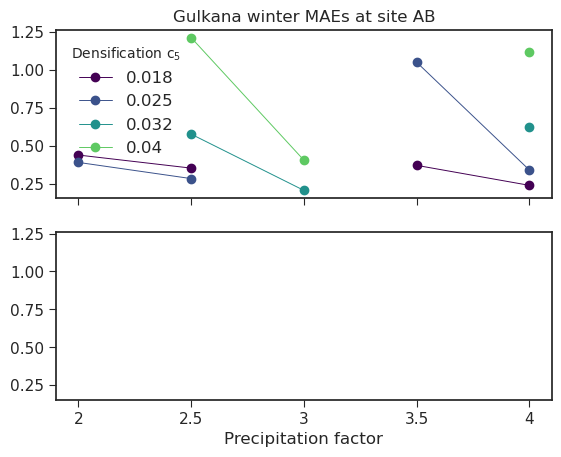

0 2024 [0.76113112        nan 4.20289261 0.44379029        nan]
0 2024 [2.11800567        nan 9.44452484 1.82788626        nan]
0 2024 [4.63173996 0.80031736        nan 4.30534615 0.73230414]
0 2024 [9.81897063 2.08172953        nan 9.3938583  1.92612477]


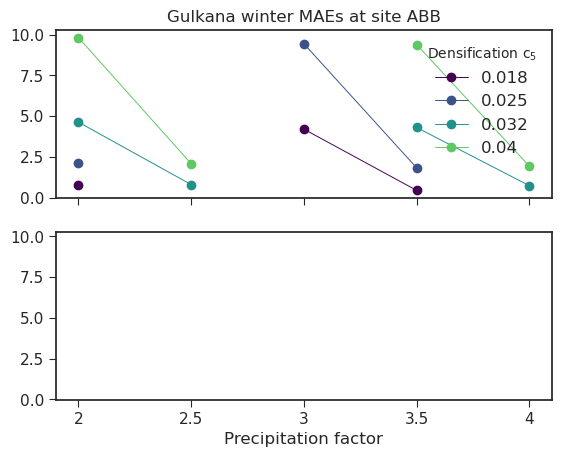

0 2024 [       nan 4.22473402 0.45961223        nan 3.90026513]
0 2024 [       nan 9.38427507 1.89182806        nan 9.00742721]
0 2024 [0.92718054        nan 4.3786276  0.72154508        nan]
0 2024 [2.18066484        nan 9.3187277  1.95937526        nan]


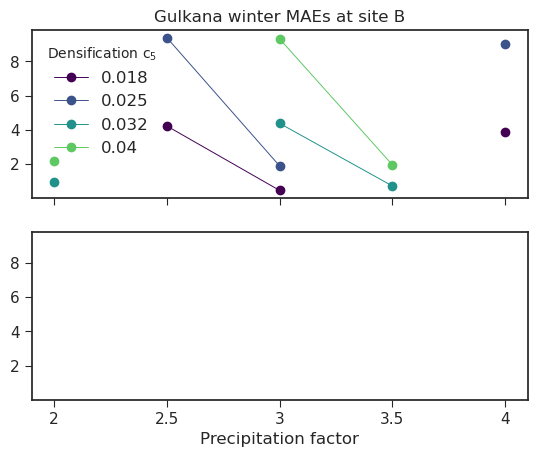

0 2024 [0.61309928 0.4424749         nan 4.0886347  0.28216697]
0 2024 [2.10327625 1.95771023        nan 9.57631345 1.63080415]
0 2024 [       nan 4.60717592 0.60806983        nan 4.24657184]
0 2024 [       nan 9.88772387 1.97317599        nan 9.5138264 ]


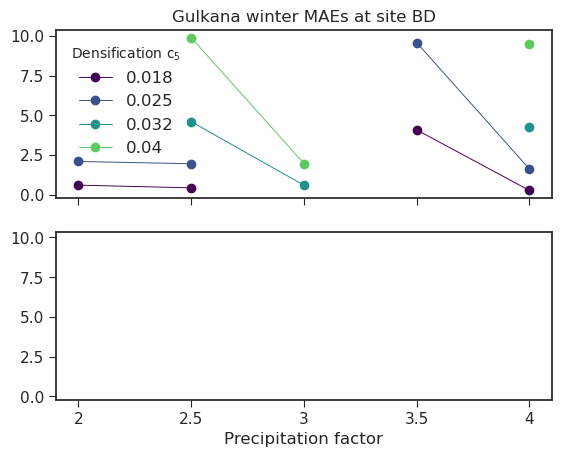

0 2024 [1.38154541        nan 3.28271178 0.94392688        nan]
0 2024 [1.76926256        nan 6.63806103 1.19369983        nan]
0 2024 [3.5916802  0.50743266        nan 3.10215091 0.66398194]
0 2024 [6.95641972 1.52485732        nan 6.48841241 1.15858874]


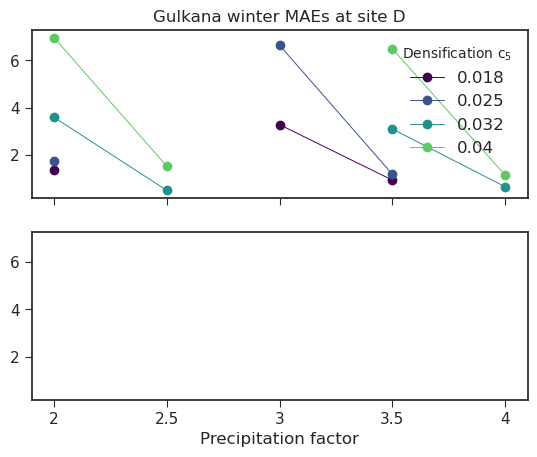

0 2024 [       nan 3.69639527 0.55033794        nan 7.48234761]
0 2024 [       nan 8.97522577 1.95621697 0.51132917        nan]
0 2024 [1.19717191        nan 4.61017954 1.86930699 0.48895196]
0 2024 [2.6405794         nan 9.07939839 4.38726107 1.72752985]


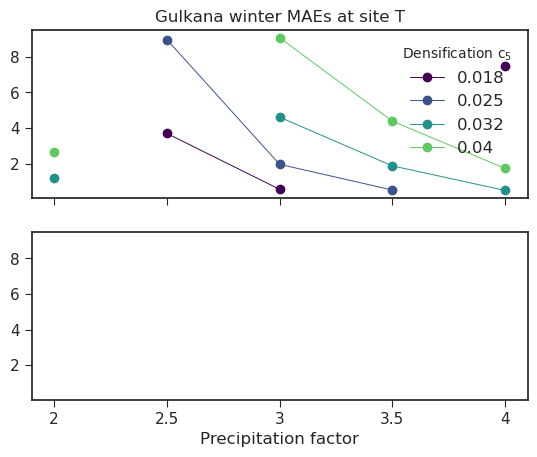

In [55]:
season = 'winter'
param_x = 'kp'
param_z = 'Boone_c5'
for site in dsdict: # ['A','B','D','mean']:
    fig,axes = plt.subplots(2,sharex=True,sharey=True)
    param_x_arr = np.array(params[param_x],dtype=str)
    param_z_arr = np.array(params[param_z],dtype=str)
    rmses = np.empty([len(param_x_arr),len(param_z_arr),2])

    if 'kw' not in [param_x,param_z]:
        kw = medians['kw']
    if 'kp' not in [param_x,param_z]:
        kp = medians['kp']
    if 'Boone_c5' not in [param_x,param_z]:
        c5 = medians['Boone_c5']

    norm = mpl.colors.Normalize(vmin=0,vmax=len(param_z_arr))
    cmap = mpl.colormaps.get_cmap('viridis')
    for ii,run in enumerate(['2024']): # ,'long'
        for zz,zval in enumerate(param_z_arr):
            for xx,xval in enumerate(param_x_arr):
                if param_x == 'kw':
                    kw = xval
                elif param_z == 'kw':
                    kw = zval
                if param_x == 'kp':
                    kp = xval
                elif param_z == 'kp':
                    kp = zval
                if param_x == 'Boone_c5':
                    c5 = xval
                elif param_z == 'Boone_c5':
                    c5 = zval
                
                if run == 'long':
                    run_name = season
                elif run == '2024':
                    run_name = run

                if site == 'mean':
                    site_vals = []
                    for s in dsdict:
                        if run_name in dsdict[s][str(kw)][str(c5)][str(kp)]:
                            site_vals.append(dsdict[s][str(kw)][str(c5)][str(kp)][run_name])
                            
                        else:
                            site_vals.append(np.nan)
                    rmses[xx,zz,ii] = np.nanmean(site_vals)
                else:
                    if run_name in dsdict[site][str(kw)][str(c5)][str(kp)]:
                        rmses[xx,zz,ii] = dsdict[site][str(kw)][str(c5)][str(kp)][run_name]
                    else:
                        rmses[xx,zz,ii] = np.nan
            print(ii,run,rmses[:,zz,ii])
            axes[ii].plot(param_x_arr,rmses[:,zz,ii],color=cmap(norm(zz)),label=str(zval),marker='o',linewidth=0.7)

    axes[0].legend(title=labels[param_z],fontsize=12)
    axes[-1].set_xlabel(labels[param_x],fontsize=12)
    title = f'Gulkana {season} MAEs'
    if site != 'mean':
        title += f' at site {site}'
    axes[0].set_title(title)
    for ax in axes:
        ax.tick_params(length=5,labelsize=11)
    # plt.savefig(f'../Output/EB/{season}_{site}.png')
    plt.show()

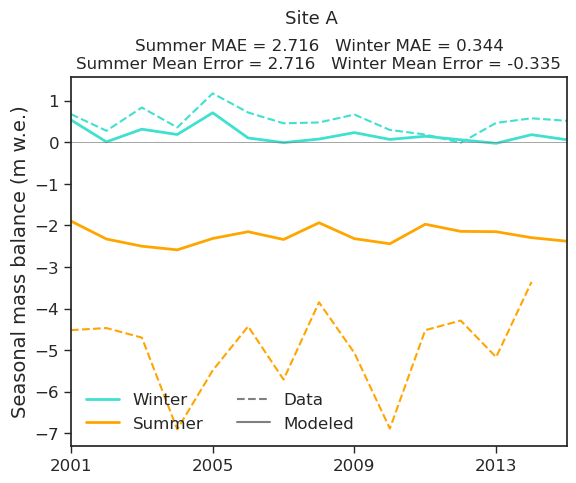

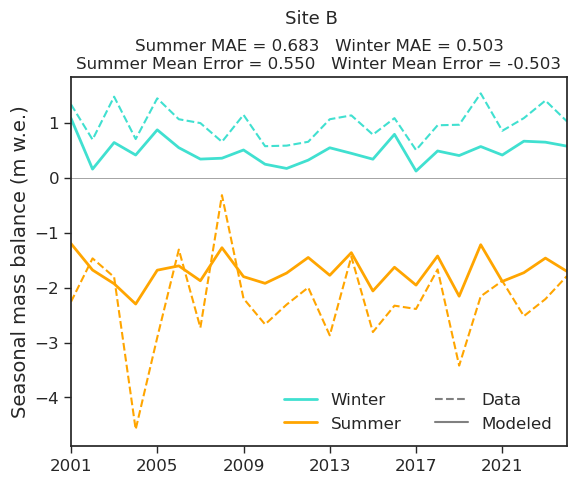

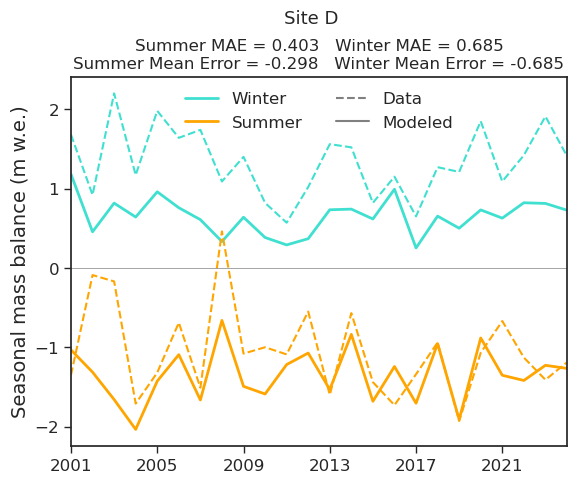

In [26]:
for site in ['A','B','D']:
    ds = dsdict[site]['0-1']['0.05']
    fig,ax = seasonal_mass_balance(site,ds,plot=True)
    fig.suptitle(f'Site {site}',y=1.02,fontsize=13)

In [6]:
result_df = pd.DataFrame(data=np.zeros((len(sites),3)),columns=sites,index=['kp','kw','a_ice'])
for site in sites:
    ds = best[site]
    result_df.loc['kp',site] = float(ds.attrs['kp'])
    if site == 'D':
        result_df.loc['kw',site] = 2 #float(ds.attrs['kw'])
        result_df.loc['a_ice',site] = 0.4
    else:
        result_df.loc['a_ice',site] = float(ds.attrs['a_ice'])
        result_df.loc['kw',site] = 3
# result_df.to_csv(f'/home/claire/research/Gulkana_params_{date}_HIGHWIND.csv',sep=',')
print(result_df)

         AB    B    D
kp     3.20  3.2  3.2
kw     3.00  3.0  2.0
a_ice  0.25  0.4  0.4


In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])